# CITS4402 Project: HOG Feature Extraction and SVM Classifier Fitting

### Group Members:

- Jalil Inayat-Hussain (22751096)
- Felix Mavrodoglu (23720305)
- Reilly Evans (23615971)

## Code without library

In [1]:
GRADIENT_FILTER = [-1, 0, 1]
NUM_OF_BINS = 9
CELL_SIZE = (8, 8)
BLOCK_SIZE = (16, 16)
DETECTION_WINDOW_SIZE = (64, 128)

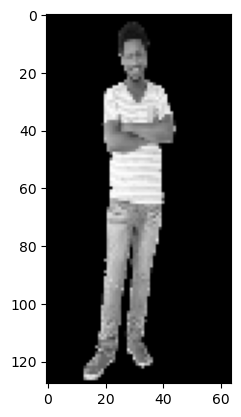

In [2]:
import cv2
import matplotlib.pyplot as plt

# 1) Load Test Image
img = cv2.imread('./man.jpg')

# Resize to 64x128 (width x height)
resized_img = cv2.resize(img, DETECTION_WINDOW_SIZE)
gray_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray_img, cmap='gray')

In [3]:
# Calculate gradients
import numpy as np

image = gray_img
image = image.astype(np.float32)

# Pad the image to handle borders
padded_image = np.pad(image, ((1,1), (1,1)), mode='edge')

gradient_x = np.zeros_like(image, dtype=np.float32)
gradient_y = np.zeros_like(image, dtype=np.float32)

rows, cols = image.shape

for i in range(rows):
    for j in range(cols):
        window = padded_image[i:i+3, j:j+3]

        gradient_x[i, j] = (window[1, 0] * -1) + (window[1, 2] * 1)
        gradient_y[i, j] = (window[2, 1] * -1) + (window[0, 1] * 1)

# Compute gradient magnitude and orientation
magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
orientation = np.arctan2(gradient_y, gradient_x) * 180 / np.pi  # in degrees


In [4]:
cell_size = CELL_SIZE[0]
num_bins = NUM_OF_BINS

# Get image dimensions
height, width = magnitude.shape
    
# Calculate cell grid dimensions
num_cells_y = height // cell_size
num_cells_x = width // cell_size
    
# Make sure orientations are in range 0-180 degrees
orientation = np.mod(orientation, 180)
    
# Initialize histogram array
histograms = np.zeros((num_cells_y, num_cells_x, num_bins))
    
# Calculate bin width and bin centers
bin_width = 180 / num_bins


In [5]:
# Get cell size
cell_size = CELL_SIZE[0]
num_bins = NUM_OF_BINS

# Get image dimensions
height, width = magnitude.shape
    
# Calculate cell grid dimensions
num_cells_y = height // cell_size
num_cells_x = width // cell_size
    
# Make sure orientations are in range 0-180 degrees
# Convert negative angles to positive equivalents
orientation = np.mod(orientation, 180)
    
# Initialize histogram array
histograms = np.zeros((num_cells_y, num_cells_x, num_bins))
    
# Calculate bin width - for 9 bins covering 0-180°, each bin is 20° wide
bin_width = 180 / num_bins
    
# For each cell
for y in range(num_cells_y):
    for x in range(num_cells_x):
        # Define cell boundaries
        y_start = y * cell_size
        y_end = (y + 1) * cell_size
        x_start = x * cell_size
        x_end = (x + 1) * cell_size
        
        # Extract cell region
        cell_magnitudes = magnitude[y_start:y_end, x_start:x_end]
        cell_orientations = orientation[y_start:y_end, x_start:x_end]
        
        # Flatten the cell arrays for easier processing
        cell_magnitudes = cell_magnitudes.flatten()
        cell_orientations = cell_orientations.flatten()
        
        # For each pixel in the cell
        for i in range(len(cell_magnitudes)):
            # Get magnitude and orientation
            mag = cell_magnitudes[i]
            angle = cell_orientations[i]
            
            binel, rem = np.divmod(angle, bin_width)

            weightR = rem*1.0/bin_width
            weightL = 1 - weightR

            deltaR = mag * weightR
            deltaL = mag * weightL

            binL = int(binel)
            binR = np.mod(binL+1, num_bins)
            histograms[y, x, binL] += deltaL
            histograms[y, x, binR] += deltaR
            

In [6]:
# Define block parameters
block_size = (2, 2)  # 2x2 cells = 16x16 pixels (assuming 8x8 pixel cells)
block_stride = (1, 1)  # 8-pixel spacing = 1 cell stride

# Calculate the number of blocks
num_blocks_y = num_cells_y - block_size[0] + 1
num_blocks_x = num_cells_x - block_size[1] + 1

# Initialize the normalized feature vector
hog_features = []

# Process each block with the specified stride
for y in range(0, num_cells_y - block_size[0] + 1, block_stride[0]):
    for x in range(0, num_cells_x - block_size[1] + 1, block_stride[1]):
        # Extract block histograms (2x2 cells)
        block_hist = histograms[y:y+block_size[0], x:x+block_size[1], :].flatten()
        
        # L2-norm
        l2_norm = np.sqrt(np.sum(block_hist**2) + 1e-10)  # Small epsilon to avoid division by zero
        
        normalized_block = block_hist / l2_norm
        
        clip_threshold = 0.2
        normalized_block = np.clip(normalized_block, 0, clip_threshold)
        
        l2_norm_again = np.sqrt(np.sum(normalized_block**2) + 1e-10)
        normalized_block = normalized_block / l2_norm_again
        
        hog_features.append(normalized_block)

hog_features = np.array(hog_features)

hog_features_reshaped = hog_features.reshape(num_blocks_y, num_blocks_x, -1)

In [7]:
#V

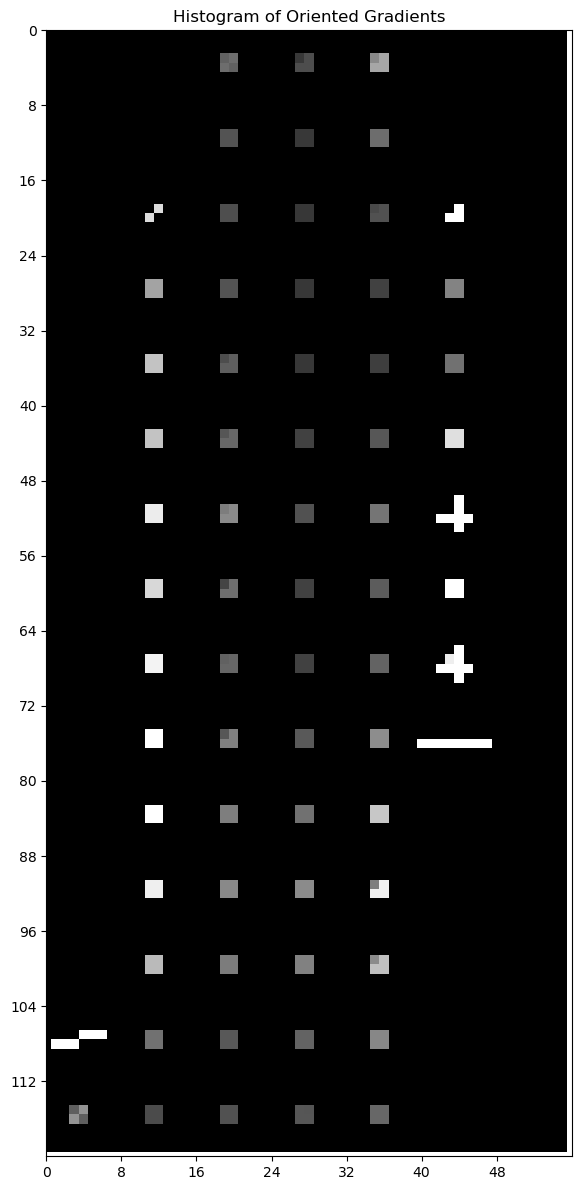

In [8]:
import numpy as np

import matplotlib.pyplot as plt
from skimage import draw

def visualize_hog_like_image(hog_features, figsize=(8, 12), cell_size=8, scale_factor=1.0):
    rows, cols, orientations = hog_features.shape
    
    # Calculate the size of the output image
    img_height = rows * cell_size
    img_width = cols * cell_size
    
    # Create a black background image
    hog_image = np.zeros((img_height, img_width), dtype=np.float32)
    
    # For each cell in the grid
    for y in range(rows):
        for x in range(cols):
            # Center coordinates of the current cell
            center_y = (y + 0.5) * cell_size
            center_x = (x + 0.5) * cell_size
            
            # Get histogram for this cell
            histogram = hog_features[y, x]
            
            # Normalize the histogram
            if np.sum(histogram) > 0:
                histogram = histogram / np.sum(histogram)
            
            # Draw lines for each orientation bin
            for orient_idx in range(orientations):
                # Calculate angle in radians (assuming angles are evenly distributed from 0 to 180 degrees)
                angle = orient_idx * (np.pi / orientations)
                
                # Scale line length based on histogram value
                line_length = histogram[orient_idx] * cell_size * 0.5 * scale_factor
                
                if line_length > 0:
                    # Calculate line endpoints
                    start_y = int(center_y - line_length * np.sin(angle))
                    start_x = int(center_x - line_length * np.cos(angle))
                    end_y = int(center_y + line_length * np.sin(angle))
                    end_x = int(center_x + line_length * np.cos(angle))
                    
                    # Ensure endpoints are within image boundaries
                    start_y = max(0, min(start_y, img_height - 1))
                    start_x = max(0, min(start_x, img_width - 1))
                    end_y = max(0, min(end_y, img_height - 1))
                    end_x = max(0, min(end_x, img_width - 1))
                    
                    # Draw the line using Bresenham's algorithm
                    rr, cc = draw.line(start_y, start_x, end_y, end_x)
                    valid_idx = (rr >= 0) & (rr < img_height) & (cc >= 0) & (cc < img_width)
                    
                    # Set intensity based on histogram value
                    hog_image[rr[valid_idx], cc[valid_idx]] = np.maximum(
                        hog_image[rr[valid_idx], cc[valid_idx]], 
                        histogram[orient_idx] * scale_factor
                    )
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Display the image with a dark background and light lines
    ax.imshow(hog_image, cmap='gray', vmin=0, vmax=0.2)  # Adjust vmax to control contrast
    
    # Set title
    ax.set_title("Histogram of Oriented Gradients")
    
    # Set axis ticks
    x_ticks = np.arange(0, img_width, cell_size)
    y_ticks = np.arange(0, img_height, cell_size)
    ax.set_xticks(x_ticks)
    ax.set_yticks(y_ticks)
    
    # Add grid lines if desired (optional - not in the example image)
    # ax.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.3)
    
    # Set proper axis limits
    ax.set_xlim(0, img_width)
    ax.set_ylim(img_height, 0)  # Reverse y-axis to match image coordinates
    
    plt.tight_layout()
    plt.show()

# Example usage:
# Create random HOG features with shape (15, 7, 36)
np.random.seed(42)  # For reproducibility
hog_features = np.random.rand(15, 7, 36)

# Visualize the HOG features with the same look as the example
visualize_hog_like_image(hog_features_reshaped, scale_factor=1.0)  # Adjust scale_factor as needed



## Using Library

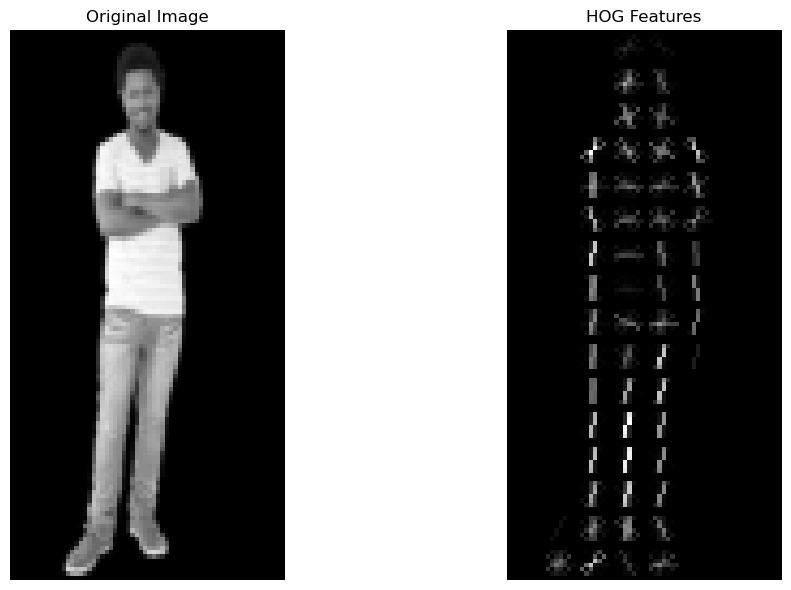

Feature vector length: 3780
Feature vector shape: (3780,)


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, transform
from skimage.feature import hog
from skimage import exposure

def compute_hog_features(image_path):
    # Read the image
    img = io.imread(image_path)
    
    # Resize to 64x128 pixels if needed
    if img.shape[0] != 128 or img.shape[1] != 64:
        img = transform.resize(img, (128, 64), anti_aliasing=True)
    
    # Convert to grayscale (handle both RGB and RGBA images)
    if len(img.shape) > 2:
        # For RGBA images (4 channels), remove the alpha channel first
        if img.shape[2] == 4:
            img = img[:, :, :3]
        gray_img = color.rgb2gray(img)
    else:
        gray_img = img
    
    # Compute HOG features with specified parameters
    features, hog_image = hog(
        gray_img,
        orientations=9,             # 9 orientation bins
        pixels_per_cell=(8, 8),     # 8x8 pixel cells
        cells_per_block=(2, 2),     # 16x16 blocks (2x2 cells)
        block_norm='L2-Hys',        # L2-Hys normalization
        visualize=True,
        feature_vector=True,
        transform_sqrt=False,       # No gamma correction
    )

    #print(features.shape)
    #print(hog_image.shape)
    
    return gray_img, features, hog_image

def visualize_hog(image_path):
    # Compute HOG features
    gray_img, features, hog_image = compute_hog_features(image_path)
    
    # Rescale HOG image for better visualization
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
    
    # Visualize original and HOG images
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    ax1.imshow(gray_img, cmap='gray')
    ax1.set_title('Original Image')
    ax1.axis('off')
    
    ax2.imshow(hog_image_rescaled, cmap='gray')
    ax2.set_title('HOG Features')
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Feature vector length: {len(features)}")
    print(f"Feature vector shape: {features.shape}")
    
    return features

image_path = "man.jpg"
features = visualize_hog(image_path)

## Constructing Model from Dataset Tarfile

The code below should grab images from a given dataset (in the form of a `.tar.gz` file) and use them to train a SVM classifier. This will use the scikit HOG calculation for now; once the structure is present it can be adapted to work with the manual implementation if necessary.

MAKE SURE TO CLEAN UP THIS NOTEBOOK BEFORE FINALISING THE PROJECT

In [10]:
DATASET_PATH = './ExampleSets/train_set.tar.gz'

In [11]:
import os
import tarfile

# Extract the training set
with tarfile.open(DATASET_PATH, 'r:gz') as tar:
    # Extract images to directory
    imageDir = tar.getmembers()[0].name
    print('Directory for set images:', imageDir)
    tar.extractall()
    # Get list of file paths for each image in dataset
    imageFiles = [os.path.join('.', img.name) for img in tar.getmembers()[1:]]

Directory for set images: train_set


Negative Image Files:
./train_set/N000000.pgm
./train_set/N000001.pgm
./train_set/N000002.pgm

Positive Image Files:
./train_set/P000000.pgm
./train_set/P000001.pgm
./train_set/P000002.pgm

HOG feature visualisation for negative training set data:



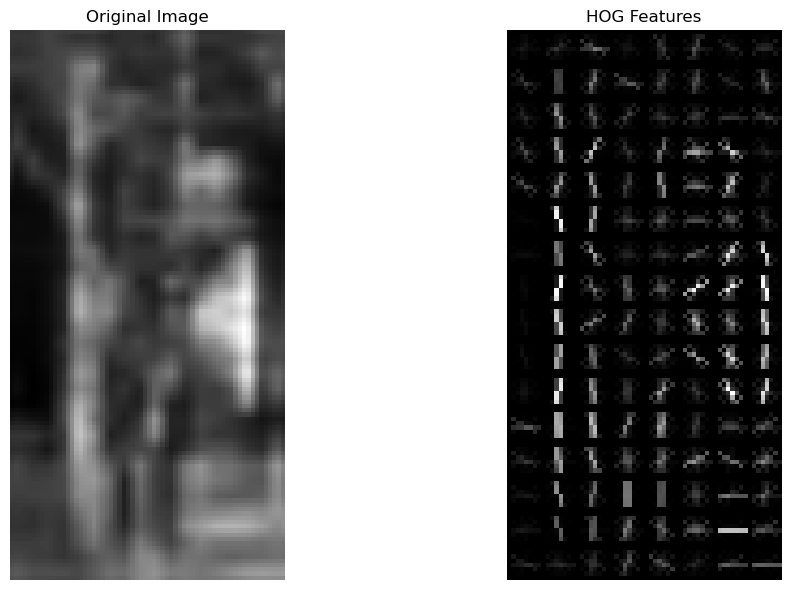

Feature vector length: 3780
Feature vector shape: (3780,)


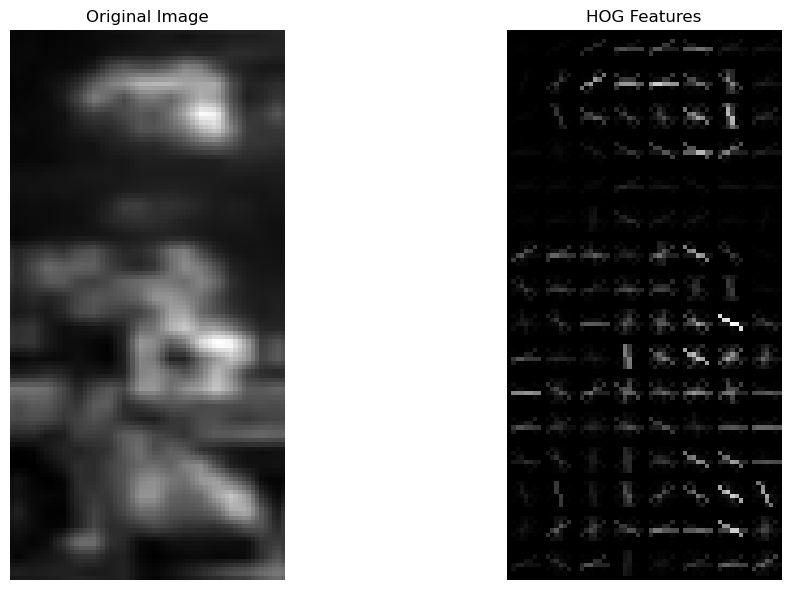

Feature vector length: 3780
Feature vector shape: (3780,)


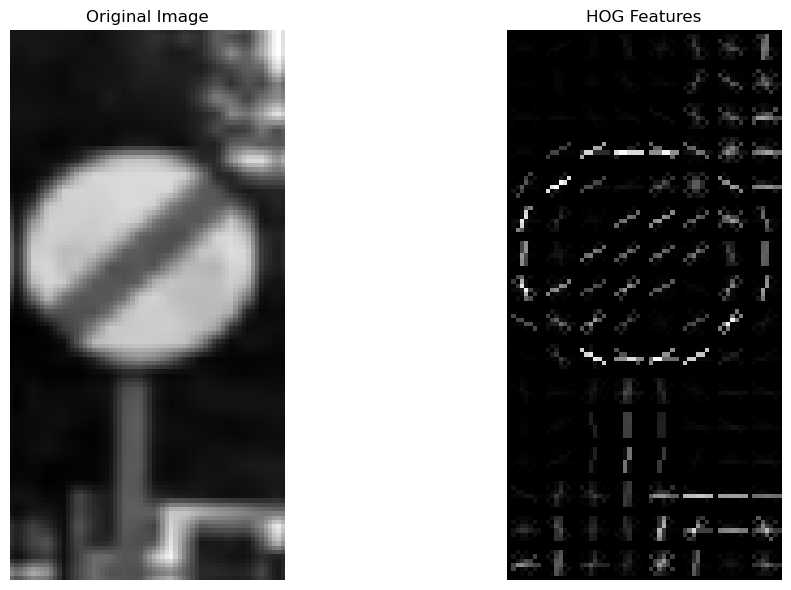

Feature vector length: 3780
Feature vector shape: (3780,)



HOG feature visualisation for positive training set data:



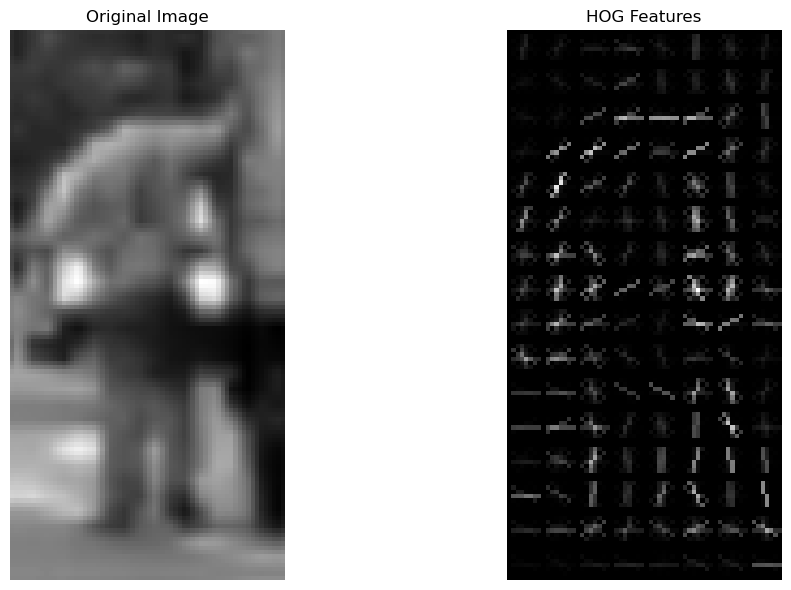

Feature vector length: 3780
Feature vector shape: (3780,)


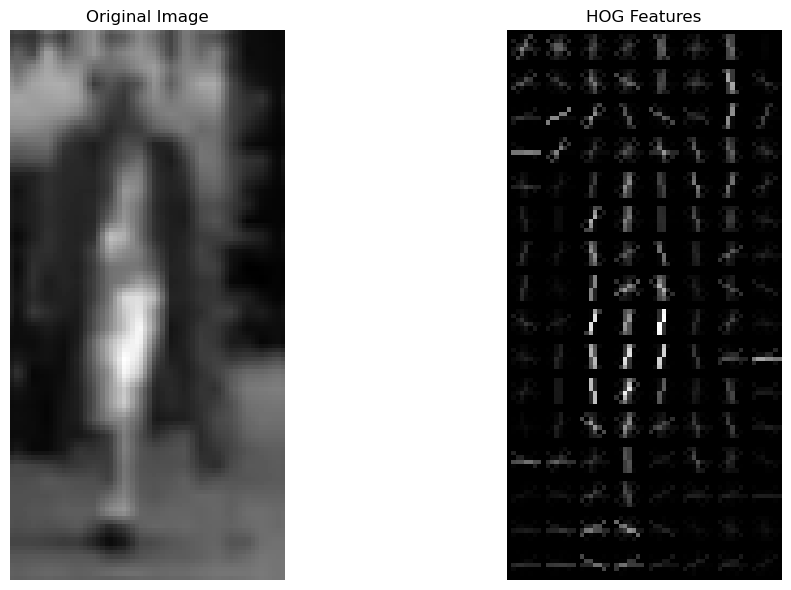

Feature vector length: 3780
Feature vector shape: (3780,)


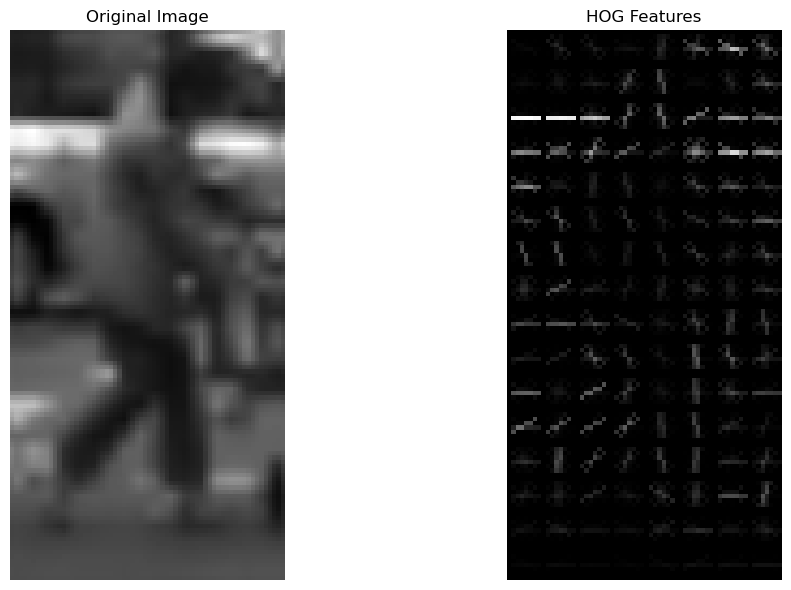

Feature vector length: 3780
Feature vector shape: (3780,)



Numeric HOG features from negative data:

[0.18673623 0.05203651 0.03821875 ... 0.01523018 0.02474662 0.        ]
[0.07233488 0.02393916 0.0511767  ... 0.07835618 0.         0.11781041]
[0.1696653  0.0353527  0.02039806 ... 0.0792181  0.16254364 0.15043683]

Numeric HOG features from positive data:

[0.30242858 0.19168583 0.11227586 ... 0.         0.         0.        ]
[0.19481295 0.26731816 0.11519408 ... 0.0266504  0.07637005 0.03657332]
[0.03300404 0.02779513 0.04972477 ... 0.00535846 0.01335025 0.        ]

Number of HOG features per image: 3780


In [12]:
# To demonstrate HOG functionality, 3 positive and 3 negative images 
# will be ran through the visualise_hog() function to display the HOG 
# features for different samples
print('Negative Image Files:')
for img in imageFiles[:3]: print(img)
print('\nPositive Image Files:')
for img in imageFiles[250:253]: print(img)

# Visualise HOG features
print('\nHOG feature visualisation for negative training set data:\n')
negativeVisualFeatures = [visualize_hog(img) for img in imageFiles[:3]]
print('\n\n\nHOG feature visualisation for positive training set data:\n')
positiveVisualFeatures = [visualize_hog(img) for img in imageFiles[250:253]]

# Display numeric feature values
print('\n\n\nNumeric HOG features from negative data:\n')
for feat in negativeVisualFeatures: print(feat)
print('\nNumeric HOG features from positive data:\n')
for feat in positiveVisualFeatures: print(feat)
print('\nNumber of HOG features per image:', len(negativeVisualFeatures[0]))

In [13]:
from sklearn.utils import shuffle

# Compute features on each image
# Original/HOG images aren't needed for model training
imageFeatures = np.array([compute_hog_features(img)[1] for img in imageFiles])

# Get positive/negative status of each image as array
imageClass = np.char.startswith(
    np.array(imageFiles), os.path.join('.', imageDir, 'P')
)

# Randomise image order with respect to features and classification
imagePath = np.array(imageFiles)
imagePath, imageFeatures, imageClass = shuffle(
    imagePath, imageFeatures, imageClass, random_state=42
)

# Print filenames and classifications together to demonstrate that
# shuffling kept attributes of each image together
# Note that files with N are false and files with P are true
for i, img in enumerate(imagePath[:10]):
    print(img + ': ' + str(imageClass[i]) + '\n')

./train_set/P000111.pgm: True

./train_set/N000073.pgm: False

./train_set/P000124.pgm: True

./train_set/N000155.pgm: False

./train_set/N000104.pgm: False

./train_set/P000144.pgm: True

./train_set/P000127.pgm: True

./train_set/N000124.pgm: False

./train_set/N000068.pgm: False

./train_set/P000200.pgm: True



In [14]:
import shutil

# Delete the training set that got unzipped
if os.path.isdir(imageDir): shutil.rmtree(imageDir)

In [15]:
from sklearn.svm import LinearSVC
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score, cross_val_predict

# Create and train SVM classifier
imageSVM = LinearSVC(random_state = 42)
imageSVM.fit(imageFeatures, imageClass)

# Get accuracy, precision and recall of SVM, using cross-validation
trainPredicts = cross_val_predict(imageSVM, imageFeatures, imageClass, cv = 3)
trainAccuracy = imageSVM.score(imageFeatures, imageClass) 
validAccuracy = cross_val_score(
    imageSVM, imageFeatures, imageClass, cv = 3, scoring="accuracy"
).mean()
print(
    'Accuracy of linear SVM classifier on Daimler training dataset:', 
    trainAccuracy
)
print(
    'Cross-validated accuracy of linear SVM classifier on Daimler training '
    'dataset:', validAccuracy
)
trainPrecision = precision_score(imageClass, trainPredicts)
print(
    'Precision of linear SVM classifier on Daimler training dataset:', 
    trainPrecision
)
trainRecall = recall_score(imageClass, trainPredicts)
print(
    'Recall of linear SVM classifier on Daimler training dataset:', 
    trainRecall
)
trainFOne = f1_score(imageClass, trainPredicts)
print(
    'F1 score of linear SVM classifier on Daimler training dataset:', 
    trainFOne
)

Accuracy of linear SVM classifier on Daimler training dataset: 1.0
Cross-validated accuracy of linear SVM classifier on Daimler training dataset: 0.9120674314022557
Precision of linear SVM classifier on Daimler training dataset: 0.912
Recall of linear SVM classifier on Daimler training dataset: 0.912
F1 score of linear SVM classifier on Daimler training dataset: 0.912


In [16]:
# Imports (repeated in case function gets isolated from this notebook)
import os
import tarfile
import shutil
import numpy as np
import cv2
from sklearn.utils import shuffle
from skimage import io, color, transform
from skimage.feature import hog

"""
Function to generate Histogram of Oriented Gradients (HOG) features and 
classifications for all images in a given tarfile, compiling the 
processing steps demonstrated above
Relies on compute_hog_features() in addition to the above imports


Parameters:
    tarfilePath: name of (or path to) the tarfile containing the images 
    that will be used to generate HOG features

    deleteDir: whether or not the directory containing the extracted 
    tarfile contents should be deleted once the function has completed

    randomSeed: NumPy seed for random selection reproducibility

Outputs:
    imagePath: NumPy array of strings corresponding to the file paths to
    each image in the dataset. Useful as an index value for the data

    imageFeatures: Nested Numpy array of numeric values representing the
    HOG features generated from each image

    imageClass: NumPy array of Booleans indicating each image was a 
    positive/human sample (True) or a negative/non-human sample (False),
    determined via the file name
"""
def formatDataset(tarfilePath, deleteDir = True, randomSeed = None):
    # Extract the training set
    with tarfile.open(tarfilePath, 'r:gz') as tar:
        # Extract images to directory
        imageDir = os.path.join('.', tar.getmembers()[0].name)
        tar.extractall()
        # Get list of image file paths
        imageFiles = [
            os.path.join('.', img.name) for img in tar.getmembers()[1:]
        ]
    # Compute HOG features
    imagePath = np.array(imageFiles)
    imageFeatures = np.array(
        [compute_hog_features(img)[1] for img in imageFiles]
    )
    imageClass = np.char.startswith(
        imagePath, os.path.join(imageDir, 'P')
    )
    imagePath, imageFeatures, imageClass = shuffle(
        imagePath, imageFeatures, imageClass, random_state=randomSeed
    )
    # Delete extracted directory before returning
    if deleteDir: shutil.rmtree(imageDir)
    return imagePath, imageFeatures, imageClass

In [17]:
# Unpack and format test set
testPath, testFeatures, testClass = formatDataset(
    './ExampleSets/test_set.tar.gz', deleteDir = True, randomSeed = 42
)

# Check test set values to confirm they were formatted correctly
print('Sampled images, classifications and features from test set:')
for i, img in enumerate(testPath[:10]):
    print(img + ': ' + str(testClass[i]))
    print(testFeatures[i], '\n')


# Get accuracy, precision and recall of SVM on test set
testPredicts = cross_val_predict(imageSVM, testFeatures, testClass, cv = 3)
testAccuracy = imageSVM.score(testFeatures, testClass) 
testValidAccuracy = cross_val_score(
    imageSVM, testFeatures, testClass, cv = 3, scoring="accuracy"
).mean()
print(
    'Accuracy of linear SVM classifier on Daimler testing dataset:', 
    testAccuracy
)
print(
    'Cross-validated accuracy of linear SVM classifier on Daimler testing '
    'dataset:', testValidAccuracy
)
testPrecision = precision_score(testClass, testPredicts)
print(
    'Precision of linear SVM classifier on Daimler testing dataset:', 
    testPrecision
)
testRecall = recall_score(testClass, testPredicts)
print(
    'Recall of linear SVM classifier on Daimler testing dataset:', 
    testRecall
)
testFOne = f1_score(testClass, testPredicts)
print(
    'F1 score of linear SVM classifier on Daimler testing dataset:', 
    testFOne
)

Sampled images, classifications and features from test set:
./test_set/N000095.pgm: False
[0.03707765 0.00900453 0.         ... 0.05543099 0.08651741 0.02426371] 

./test_set/N000015.pgm: False
[0.         0.         0.         ... 0.11624729 0.01102228 0.02884874] 

./test_set/N000030.pgm: False
[0.25942172 0.02057852 0.01109461 ... 0.08066572 0.14490706 0.14562517] 

./test_set/P000058.pgm: True
[0.16268713 0.01732786 0.         ... 0.         0.         0.        ] 

./test_set/P000028.pgm: True
[0.04324197 0.         0.30570154 ... 0.02437502 0.01747602 0.01056905] 

./test_set/P000015.pgm: True
[0.33354965 0.0850538  0.         ... 0.00529964 0.0088926  0.05167742] 

./test_set/N000069.pgm: False
[0.14131283 0.14493111 0.2531122  ... 0.03442933 0.         0.        ] 

./test_set/P000070.pgm: True
[0.07651448 0.08486185 0.03532307 ... 0.00063271 0.00195316 0.00076102] 

./test_set/P000074.pgm: True
[0.17799829 0.0566425  0.00603117 ... 0.06807985 0.05890709 0.02551458] 

./test_se

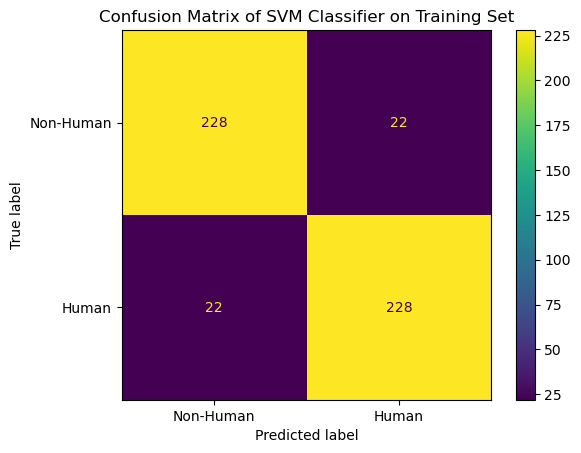

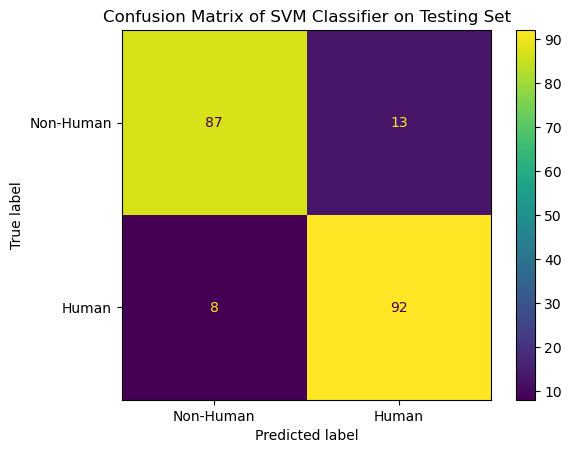

In [18]:
# Confusion matrices; not sure if these would be needed for the project 
# but I'll keep them here for now; they display more or less the same 
# info as precision and recall in a fancier package
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(
    imageClass, trainPredicts, display_labels = ['Non-Human', 'Human']
)
plt.title('Confusion Matrix of SVM Classifier on Training Set')
plt.show()

ConfusionMatrixDisplay.from_predictions(
    testClass, testPredicts, display_labels = ['Non-Human', 'Human']
)
plt.title('Confusion Matrix of SVM Classifier on Testing Set')
plt.show()